# <center>**Trabajo Práctico Número 3**</center>

### <center>**Detector de SPAM**</center>

#### <center>Introducción a la Inteligencia Artificial - CEIA & DPLN, Fiuba</center>

<center><img width="35%" src="https://lh5.googleusercontent.com/cPAoMij8-mRhQEFe6cf2R1bncilBk29i0DaUS7EkqUcLb4IdcbjCUaBXcU9k-T59JJDuOkvsB_PDdKa0F3Q54_sAdIi_4tNK5oHYmT20OLV64mFLoiq2G2L-9ihkDdgJSg=w1280"/></center>

---

**Integrantes del grupo**

- Argento, Lucas
- Espínola, Carla
- Gambarte, Antonella
- Putrino, Daniela
- Silvera, Ricardo

---


Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo. En este conjunto de datos ya se ha aplicado un procesamiento típico del campo de Procesamiento de Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los mensajes.

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras ha sido normalizada. El conjunto de datos está compuesto por 54 columnas de atributos denominadas:

    word_freq_XXXX: donde XXXX representa una palabra o símbolo. Los valores son enteros que van de 0 a 20.000.

Además, incluye una columna adicional llamada **spam, que toma el valor 1 si el correo es SPAM, y 0 si no lo es.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlaespinola/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('spambase.csv')
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,310,0,620,0,0,310,0,0,0,0,...,310,0,0,0,232,0,0,0,0,0
4597,0,0,0,0,0,0,0,0,0,0,...,2000,0,0,0,0,0,353,0,0,0
4598,300,0,300,0,0,0,0,0,0,0,...,1200,0,0,102,718,0,0,0,0,0
4599,960,0,0,0,320,0,0,0,0,0,...,320,0,0,0,57,0,0,0,0,0


In [3]:
#Análisis descriptivo
df.groupby('spam').describe()

word_freq_make                                                        \
              count        mean         std  min  25%  50%    75%     max   
spam                                                                        
0            2788.0   73.479197  297.838434  0.0  0.0  0.0    0.0  4340.0   
1            1813.0  152.338665  310.644921  0.0  0.0  0.0  170.0  4540.0   

     word_freq_address              ... char_freq_$         char_freq_#  \
                 count        mean  ...         75%     max       count   
spam                                ...                                   
0               2788.0  244.465208  ...         0.0  2037.0      2788.0   
1               1813.0  164.649752  ...       211.0  6003.0      1813.0   

                                                           
           mean         std  min  25%  50%   75%      max  
spam                                                       
0     21.713056  243.911642  0.0  0.0  0.0   0.0   7407.0  
1     78.876448  611.940076  0.0  0.0  0.0  18.0  19829.0  

[2 rows x 432 columns]

In [4]:
df.value_counts('spam')

spam
0    2788
1    1813
Name: count, dtype: int64

In [5]:
#Desbalance de clases
# 65% de proporción de no spam
print(round(df.value_counts('spam')[1]/df.value_counts('spam')[0]*100))

65


### **1. ¿Cuáles son las 10 palabras o símbolos más frecuentes en correos SPAM y en correos NO SPAM?**

    * ¿Hay palabras o símbolos en común?
    * ¿Alguna resulta llamativa?


In [6]:
#Separamos el df en spam y no spam
df_spam = df[df['spam'] == 1]
df_no_spam = df[df['spam'] == 0]

X = df.columns.drop('spam')

#Nos quedamos con las 10 columnas de mayor frecuencia para cada clase
top_10_spam = df_spam[X].sum().nlargest(10)
top_10_no_spam = df_no_spam[X].sum().nlargest(10)

print(top_10_spam)

word_freq_you         4105599
word_freq_your        2502597
word_freq_will         997100
word_freq_free         939790
word_freq_our          931799
char_freq_!            931352
word_freq_all          732080
word_freq_mail         635470
word_freq_email        578759
word_freq_business     521250
dtype: int64


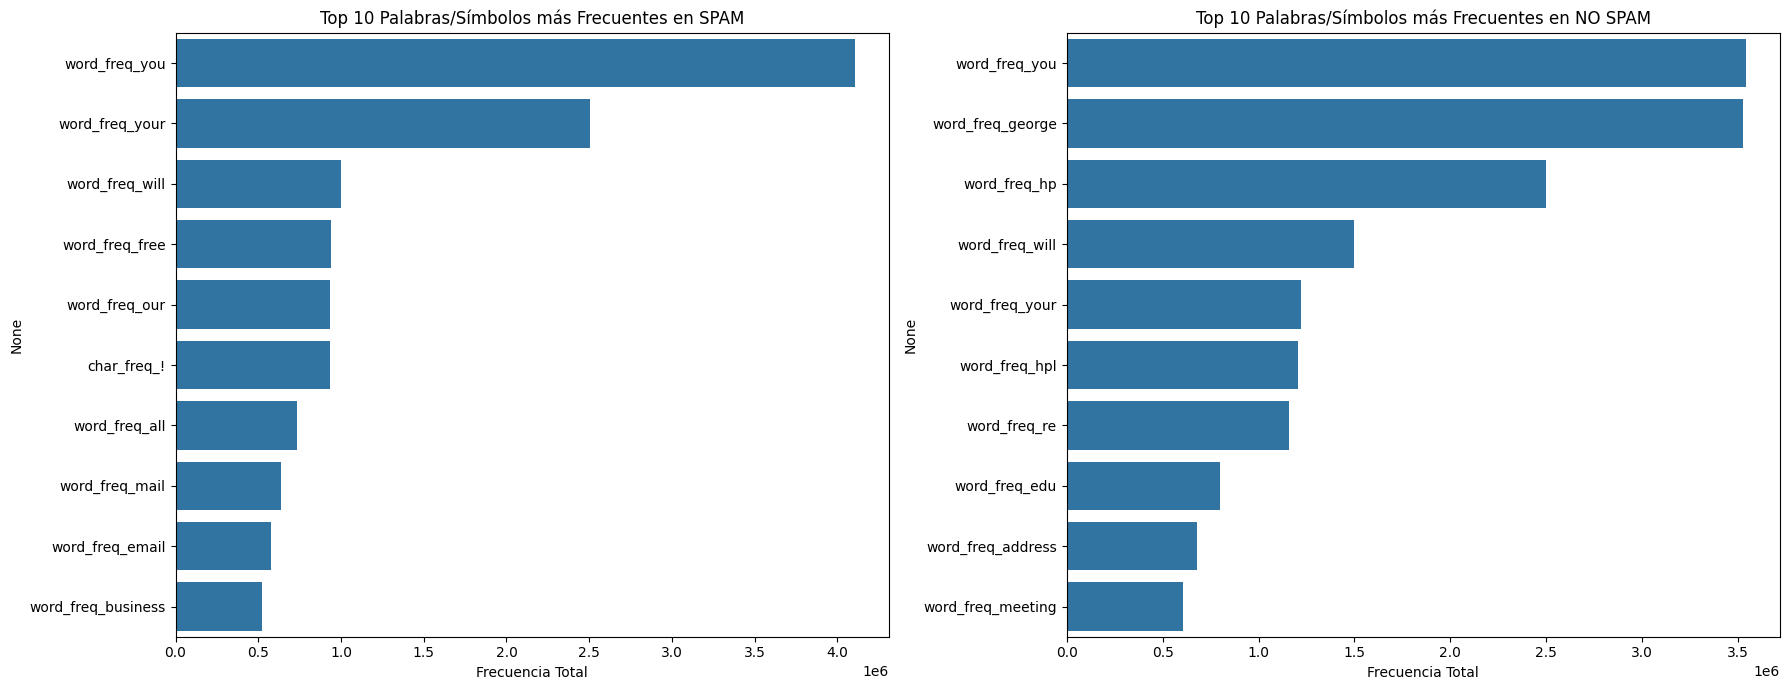

In [7]:
#Graficamos los resultados
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(x=top_10_spam.values, y=top_10_spam.index, ax=axes[0])
axes[0].set_title('Top 10 Palabras/Símbolos más Frecuentes en SPAM')
axes[0].set_xlabel('Frecuencia Total')

sns.barplot(x=top_10_no_spam.values, y=top_10_no_spam.index, ax=axes[1])
axes[1].set_title('Top 10 Palabras/Símbolos más Frecuentes en NO SPAM')
axes[1].set_xlabel('Frecuencia Total')

plt.tight_layout()
plt.show()

In [8]:
#¿Hay palabras/símbolos en común? ¿Cuáles?
top_10_spam.index.intersection(top_10_no_spam.index)

Index(['word_freq_you', 'word_freq_your', 'word_freq_will'], dtype='object')

La palabra "you" es compartida por ambas clases de mails.
Vamos a volver a hacer la comparativa sin stopwords:


In [9]:
#Cargamos las stopwords de inglés
stop_words = set(stopwords.words('english'))

print("Hay", len(stop_words), "stopwords en inglés.")
print("Algunos ejemplos:", list(stop_words)[:4])

Hay 198 stopwords en inglés.
Algunos ejemplos: ["we'd", 'such', 'our', 'all']


Número de columnas de frecuencia original: 54
Número de columnas después de quitar stopwords: 47


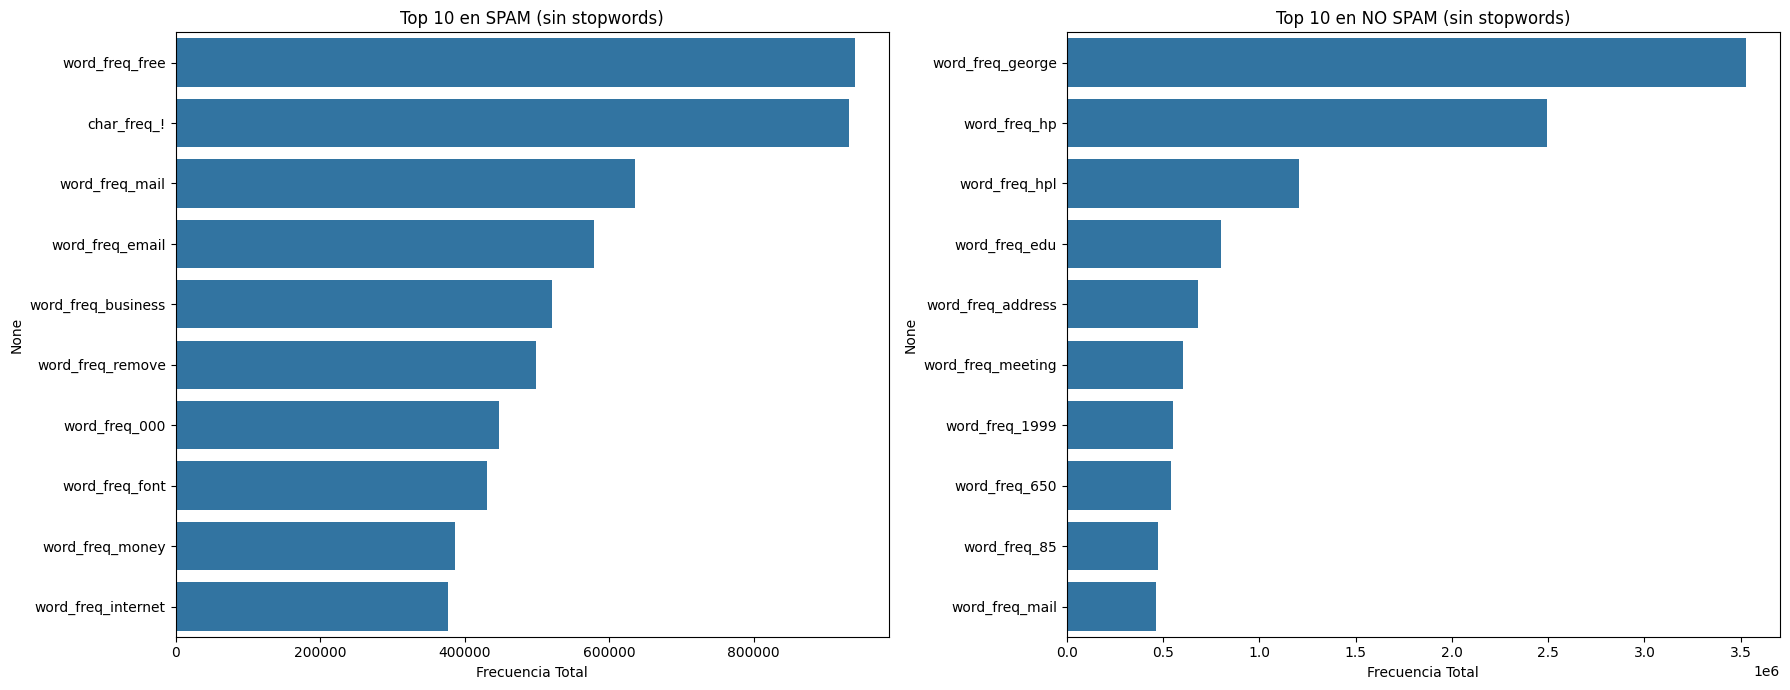

In [10]:
# Filtramos las columnas para excluir las que son stopwords
col_no_stopwords = []
for col in X:
    if col.startswith('word_freq_'):
        word = col.replace('word_freq_', '')
        if word not in stop_words:
            col_no_stopwords.append(col)
    else:
        col_no_stopwords.append(col)

print(f"Número de columnas de frecuencia original: {len(X)}")
print(f"Número de columnas después de quitar stopwords: {len(col_no_stopwords)}")

top_10_spam_no_sw = df_spam[col_no_stopwords].sum().nlargest(10)
top_10_no_spam_no_sw = df_no_spam[col_no_stopwords].sum().nlargest(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(x=top_10_spam_no_sw.values, y=top_10_spam_no_sw.index, ax=axes[0])
axes[0].set_title('Top 10 en SPAM (sin stopwords)')
axes[0].set_xlabel('Frecuencia Total')

sns.barplot(x=top_10_no_spam_no_sw.values, y=top_10_no_spam_no_sw.index, ax=axes[1])
axes[1].set_title('Top 10 en NO SPAM (sin stopwords)')
axes[1].set_xlabel('Frecuencia Total')

plt.tight_layout()
plt.show()

In [11]:
#¿Hay palabras/símbolos en común? ¿Cuáles?
top_10_spam_no_sw.index.intersection(top_10_no_spam_no_sw.index)

Index(['word_freq_mail'], dtype='object')

Ahora podemos notar que hay números en ambas clases que nos ha llamado la atención.
Comparten "mail" entre las más frecuentes.
Aún así lo relevanta para diferenciarlas son:

1. En SPAM aparece el caracter !, y las palabras free y money como claves y discriminantes.
2. Mientras que en No spam son comunes los nombres propios y referencias a meetings o address.


### **2. Separe el conjunto de datos en un conjunto de entrenamiento (70%) y uno de prueba (30%).**


In [12]:
#Separamos dataset en train y test
#Usamos stratify dado que las clases No están balanceadas, como se observó al ppio., con un 65% de registros de No spam, de modo de conservar la proporción en ambos sets.
X = df.drop('spam', axis=1)
y = df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### **3. Utilizando un clasificador de Bayes ingenuo, entrene el modelo con el conjunto de entrenamiento.**


# Modelo Bayesiano Ingenuo


In [13]:
nb_gauss = GaussianNB()
nb_gauss.fit(X_train, y_train)

y_pred_nb_gauss = nb_gauss.predict(X_test)

print(classification_report(y_test, y_pred_nb_gauss))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       837
           1       0.69      0.95      0.80       544

    accuracy                           0.81      1381
   macro avg       0.82      0.84      0.81      1381
weighted avg       0.85      0.81      0.81      1381



In [14]:
#Entrenamos un Multinomial Bayesiano ingenuo dado que encontramos que es mejor para estos casos que Gaussian:
# "The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification)" de la docu de sklearn
nb_multi = MultinomialNB()
nb_multi.fit(X_train, y_train)

y_pred_nb_multi = nb_multi.predict(X_test)

print(classification_report(y_test, y_pred_nb_multi))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       837
           1       0.77      0.96      0.86       544

    accuracy                           0.87      1381
   macro avg       0.87      0.89      0.87      1381
weighted avg       0.89      0.87      0.87      1381



### **4.Utilizando un clasificador de Regresión Logística, entrene el modelo con el conjunto de entrenamiento (en este caso, normalice los datos).**


# Regresión Logística


In [15]:
#Estandarizamos para regresión logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       837
           1       0.81      0.96      0.88       544

    accuracy                           0.90      1381
   macro avg       0.89      0.91      0.89      1381
weighted avg       0.91      0.90      0.90      1381



/Users/carlaespinola/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### **5. Calcule la matriz de confusión en el conjunto de prueba para ambos modelos.**

    * ¿Qué tipo de error comete más cada modelo?
    * ¿Cuál de los dos tipos de error considera más importante en este problema?


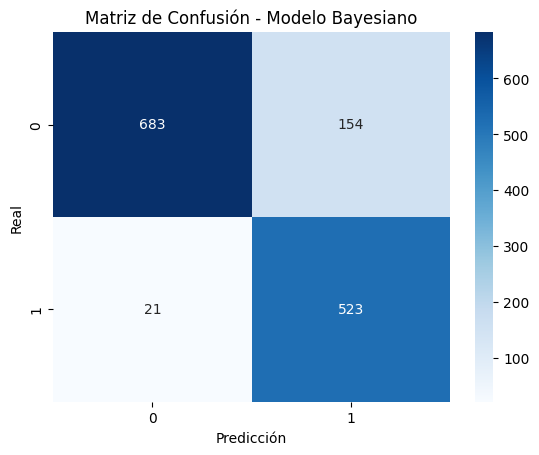

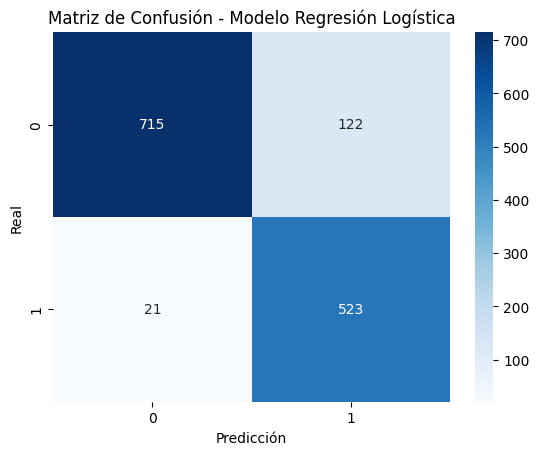

In [17]:
def plot_confusion(cm, title):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

cm_nb = confusion_matrix(y_test,y_pred_nb_multi)
cm_lr = confusion_matrix(y_test, y_pred_lr)

plot_confusion(cm_nb, "Matriz de Confusión - Modelo Bayesiano")
plot_confusion(cm_lr, "Matriz de Confusión - Modelo Regresión Logística")

Como se puede observar, en ambos modelos el error más común es el de falsos positivos, es decir, clasificar un correo como spam cuando en realidad no lo es. En menor medida, se comete el error de clasificar un correo como no spam cuando en realidad sí lo es.

De estos errores, el más importante es el de falso positivo, ya que si se trata de un correo importante para el usuario y se lo clasifica como spam, el impacto puede llegar a ser significativo ya que dicho correo es descartado.


### **6. Calcule las métricas de precisión (precision) y recuperación (recall) para ambos modelos.**
- ¿Cuál es el mejor modelo según cada métrica?
- ¿Cómo se relacionan estas métricas con los errores analizados en el punto anterior? Fundamente su respuesta.

In [18]:
# Calculo precision y recall para Naive Bayes
precision_nb = precision_score(y_test, y_pred_nb_multi)
recall_nb = recall_score(y_test, y_pred_nb_multi)

print(f"Métricas para el Modelo Bayesiano (Multinomial):")
print(f"-  Precision: {precision_nb:.4f}")
print(f"-  Recall: {recall_nb:.4f}")
print("-"*50)

# Calculo precision y recall para Regresión Logística
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)

print(f"Métricas para el Modelo de Regresión Logística:")
print(f"-  Precision: {precision_lr:.4f}")
print(f"-  Recall: {recall_lr:.4f}")

Métricas para el Modelo Bayesiano (Multinomial):
-  Precision: 0.7725
-  Recall: 0.9614
--------------------------------------------------
Métricas para el Modelo de Regresión Logística:
-  Precision: 0.8109
-  Recall: 0.9614


En cuando a recall (reconocimiento de spams que realmente son spams), ambos modelos son muy buenos.
Sin embargo, la regresión logística comete menos errores de falso positivo y por eso tiene mejor precisión.
Esto se da debido a las fórmulas que se usan para calcular estas métricas. Donde se observa que la fórmula de precisión es la única afectada, dado que el único número que cambia en los utilizados es el FP.

Fórmulas:
- Precisión = TP / (TP + FP) 
- Recall = TP / (TP + FN)

### **7.  Obtenga la curva ROC y el AUC (Área Bajo la Curva ROC) de ambos modelos.**

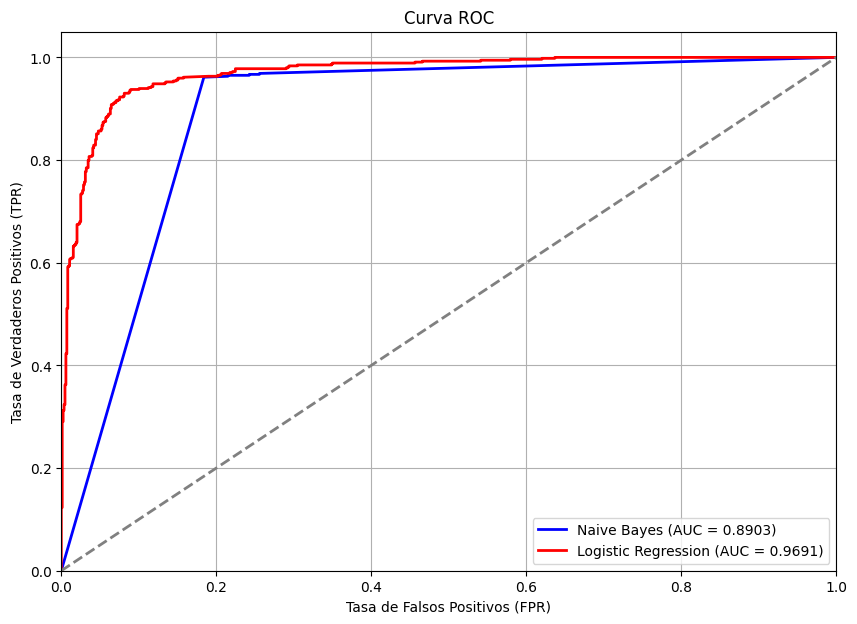

AUC para el Modelo Bayesiano (Multinomial): 0.8903
AUC para el Modelo de Regresión Logística: 0.9691


In [19]:
# Obtengo probabilidades asignadas por cada modelo para la clase positiva (spam)
y_prob_nb = nb_multi.predict_proba(X_test)[:, 1]
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Calculo cuva ROC y AUC
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)

auc_nb = auc(fpr_nb, tpr_nb)
auc_lr = auc(fpr_lr, tpr_lr)

# Grafico
plt.figure(figsize=(10, 7))
plt.plot(fpr_nb, tpr_nb, color='blue', lw=2, label=f'Naive Bayes (AUC = {auc_nb:.4f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC para el Modelo Bayesiano (Multinomial): {auc_nb:.4f}")
print(f"AUC para el Modelo de Regresión Logística: {auc_lr:.4f}")

#### Conclusión:
Dados los resultados, el modelo de regresión logística es más preciso identificando no spam y, por lo tanto, mejor dado que es más importante no perder un mail crítico entre los spam.
Sin embargo, son notables las métricas del modleo bayesiano teniendo en cuenta su simplicidad.